# **Redes Neuronales Artificiales**
# Mini-Proyecto # 1. Desarrollo de un Auto-Encoder - Clasificador de Rostros
<img style="float: right; padding-right: 10px;" height="220" src="https://drive.google.com/uc?id=0BzGoTc_BVojJUGJvMWRQVVllV0U"> <br>**Universidad del Valle** <br>
**Escuela de Ingeniería Eléctrica y Electrónica** <br>
**Área de Informática Industrial** <br>

**Profesor:** Wilfredo Alfonso Morales <br>
**Estudiante:** Juan José López Flórez - 1730514 <br>
**Enlace DRIVE:** https://drive.google.com/drive/folders/1DDbi3ZKmb5YuvAAYjgATDYc38thlxjXU?usp=sharing <br>



# Introducción

Con este miniproyecto se busca realizar un análisis de sensiblidad respecto a los hiper-parámetros del modelo de un auto-enconder que sirva como codificador de datos para clasificación de rostros.

Para esto, el auto-encoder recibe como entrada las imágenes de 37 personas distintas ya etiquetadas de Yale B dataset, y reconstruye de la mejor manera posible el rostro suministrado. 

Además, para verificar el rendimiento del sistema, se crea un clasificador usando la función de activación softmax, cuyo objetivo es identificar cada rostro según su etiqueta. Por lo tanto, para medir el rendimiento del clasificador se utilizan las métricas accuracy y loss.

Finalmente se prueban las distintas configuraciones posibles, se realiza un análisis de sensiblidad, se escoge la mejor red y se presenta un informe de los resultados obtenidos.


# Objetivos
En este mini-proyecto se construirá un _**auto-encoder**_ usando el *framework* `Keras`. Sin embargo, lo más importante no es hacer el **auto-encoder** sino determinar la sensibilidad que los modelos de las redes *deep* tienen respecto a los hiper-parámetros.

* Construir una *deep network* tipo **auto-encoder** en un problema abierto.
* Plantear al menos tres topologías de redes para resolver el problema.
* Verificar la sensibilidad de la red neuronal ante cambios en al menos tres tamaños del *batch*.
* Verificar la sensibilidad de la red neuronal ante cambios en al menos tres funciones de activación en las capas ocultas (tenga en cuenta que el problema puede sólo tener una única función de activación en la capa de salida tipo *softmax* para clasificación o *linear* para problemas de identificación).
* Verificar la sensibilidad de la red neuronal ante mecanismos de regularización (L2 y dropout)
* Verificar la sensibilidad de la red neuronal ante cambios en al menos tres algoritmos de optimización.
* Determine la mejor configuración y argumente el resultado obtenido respecto al problema.

# Desarrollo

> A continuación se presentan los desarrollos realizados para completar el miniproyecto 1 de Redes Neuronales.
Primero se presenta la configuración del drive e importe de las librerias necesarias para el diseño del auto-encoder. Segundo, se cargan las imágenes que se utilizarán para entrenamiento y test. Después, se presenta el diseño de tres topologías para el auto-encoder, con su respectivo entrenamiento y validación. También, se realiza un análisis de sensibilidad de la mejor topología con el propósito de cumplir con los objetivos planteados anteriormente. Y finalmente, se presentan los resultados y se concluye.


## 1.   Configuración del drive e importación de librerias







In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Miniproyecto1/'
input_images_path = '/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Miniproyecto1/CroppedYale/'
train_images_path = '/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Miniproyecto1/dataset/train_images/'
test_images_path = '/content/drive/MyDrive/Universidad - Ingeniería Electrónica/9 Semestre/Redes Neuronales (2022)/Miniproyecto1/dataset/test_images/'

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
import glob
import shutil
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

## 2.   Preparación de datos

> Para el presente proyecto se utiliza una parte del Yale B dataset que ya está alineado, cortado y redimensionado a 192x168 pixeles. Este cuenta con 2452 imágenes de 37 personas en diferentes condiciones de iluminación.

**Nota:* no es necesario correr las siguientes dos lineas de código. Se hizo inicialmente para generar las carpetas con imágenes aleatorias de entrenamiento y prueba en formato .jpg

In [ ]:
sujetos = ['01','02','03','04','05','06','07','08','09','10','11','12','13','15','16','17','18','19','20',
           '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39'] # Hay imágenes de 38 personas, el sujeto 14 no existe en la base de datos.
files_names = []

for suj in sujetos:
  files_names.extend(os.listdir(input_images_path + 'yaleB{}/'.format(suj))) # Se hace una copia del nombre de cada archivo que hay en cada carpeta.
  os.mkdir(train_images_path + 'yaleB{}/'.format(suj))
  os.mkdir(test_images_path + 'yaleB{}/'.format(suj))
  
for suj in sujetos:
  for file_name in files_names:
      if file_name.split(".")[-1] not in ["pgm"]: # Se hace un condicional para que solo se utilicen los archivos .pgm
        continue
      if file_name.split("_")[0] != ('yaleB{}'.format(suj)):
        continue
      image_path = input_images_path + 'yaleB{}/'.format(suj) + file_name # Se genera la ruta de cada imagen.
      image = cv2.imread(image_path)
      cv2.imwrite(train_images_path + 'yaleB{}/'.format(suj) + file_name.split(".")[0] + '.jpg', image) # Se guardan las imágenes en la carpeta train_images con extensión .jpg

In [ ]:
for suj in sujetos:
  sample = random.sample(os.listdir(train_images_path + 'yaleB{}/'.format(suj)), 15) # selecciona al azar 15 (al rededor del 23%) de las imágenes de cada carpeta para pasarlas a la carpeta de test_images
  for sam in sample:
    shutil.copy(train_images_path + 'yaleB{}/'.format(suj) + sam, test_images_path + 'yaleB{}/'.format(suj)) # copiamos las imágenes en la carpeta test_images
    os.remove(train_images_path + 'yaleB{}/'.format(suj) + sam) #eliminamos las imágenes seleccionadas de la carpeta train_images

## 3. Cargar datos
> Se generan los vectores de entrada con la información de las imágenes de entrenamiento y test.





In [3]:
# Cargar las imágenes para entrenamiento y test con un size de 96x84 pixeles. Esto se hizo por cuestiones de carga computacional y tiempos de ejecución.
train_generator = tf.keras.preprocessing.image_dataset_from_directory(train_images_path, image_size = (96, 84), batch_size=1, color_mode='grayscale')
test_generator = tf.keras.preprocessing.image_dataset_from_directory(test_images_path, image_size = (96, 84), batch_size=1, color_mode='grayscale')

Found 1882 files belonging to 38 classes.
Found 570 files belonging to 38 classes.


In [4]:
# Arreglos para extraer vectores de imágenes y etiquetas.
train_images = []
train_labels = []
test_images = []
test_labels = []

for x, y in train_generator:
  train_images.append(x)
  train_labels.append(y)

for x, y in test_generator:
  test_images.append(x)
  test_labels.append(y)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

In [5]:
# Reshape de los datos de entrenamiento y test.
x_train = train_images.reshape((len(train_images), np.prod(train_images.shape[1:])))
x_test = test_images.reshape((len(test_images), np.prod(test_images.shape[1:])))
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Etiquetas entrenamiento y test.
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

Sujeto #[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(1882, 8064)
(570, 8064)


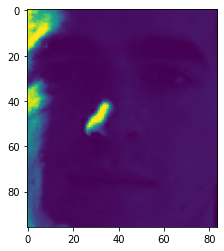

In [6]:
# Muestra de ejemplo
print('Sujeto #{}'.format(y_train[40]))
print(x_train.shape)
print(x_test.shape)
plt.imshow(x_train[40].reshape(96,84))

## 4. Topologías para el Auto-encoder

### 4.1 Topología 1: Auto-encoder
> Se diseña con 2 capas de codificación y decodificación. En cada capa se busca reducir el tamaño a la mitad.





In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='relu')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='relu')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='relu')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='relu')(decoded_second)

In [ ]:
full_autoencoder_t1 = keras.Model(input_img, decoded_first)
full_autoencoder_t1.summary() # Construcción del Autoencoder 1

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_4 (Dense)             (None, 4032)              32518080  
                                                                 
 dense_5 (Dense)             (None, 2016)              8130528   
                                                                 
 dense_6 (Dense)             (None, 4032)              8132544   
                                                                 
 dense_7 (Dense)             (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1 = full_autoencoder_t1.fit(x_train, x_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
95/95 [==============================] - 52s 545ms/step - loss: 0.1741 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 2/30
95/95 [==============================] - 53s 557ms/step - loss: 0.0161 - accuracy: 0.0027 - val_loss: 0.0155 - val_accuracy: 0.0018
Epoch 3/30
95/95 [==============================] - 50s 527ms/step - loss: 0.0142 - accuracy: 0.0021 - val_loss: 0.0150 - val_accuracy: 0.0018
Epoch 4/30
95/95 [==============================] - 51s 533ms/step - loss: 0.0124 - accuracy: 0.0032 - val_loss: 0.0118 - val_accuracy: 0.0035
Epoch 5/30
95/95 [==============================] - 50s 527ms/step - loss: 0.0109 - accuracy: 0.0032 - val_loss: 0.0114 - val_accuracy: 0.0105
Epoch 6/30
95/95 [==============================] - 51s 540ms/step - loss: 0.0095 - accuracy: 0.0064 - val_loss: 0.0106 - val_accuracy: 0.0035
Epoch 7/30
95/95 [==============================] - 57s 604ms/step - loss: 0.0091 - accuracy: 0.0080 - val_loss: 0.0089 - val_accuracy

In [ ]:
decoded_imgs = full_autoencoder_t1.predict(x_test)
full_autoencoder_t1.save(path + 'encoder_t1.h5')

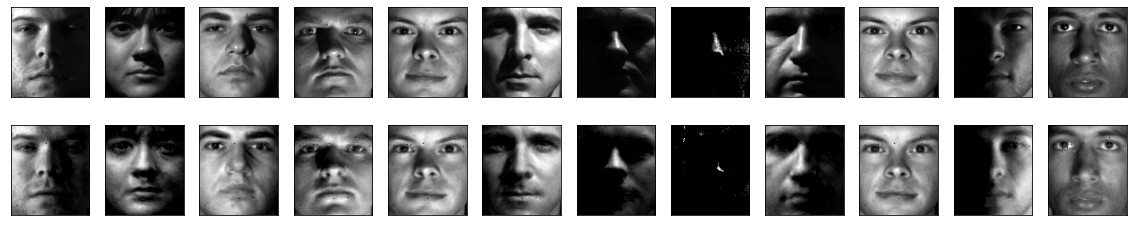

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Cargando modelo del encoder 1
encoder1 = keras.models.load_model(path + 'encoder_t1.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1.get_layer('dense_5').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1.get_layer('input_2').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 29s 297ms/step - loss: 3.3896 - accuracy: 0.1913 - val_loss: 2.5416 - val_accuracy: 0.4298
Epoch 2/30
95/95 [==============================] - 35s 370ms/step - loss: 1.9436 - accuracy: 0.5824 - val_loss: 1.4349 - val_accuracy: 0.7509
Epoch 3/30
95/95 [==============================] - 32s 335ms/step - loss: 1.1920 - accuracy: 0.7949 - val_loss: 1.0158 - val_accuracy: 0.8175
Epoch 4/30
95/95 [==============================] - 30s 316ms/step - loss: 0.8565 - accuracy: 0.8714 - val_loss: 0.7981 - val_accuracy: 0.8526
Epoch 5/30
95/95 [==============================] - 31s 326ms/step - loss: 0.6829 - accuracy: 0.9006 - val_loss: 0.6507 - val_accuracy: 0.8702
Epoch 6/30
95/95 [==============================] - 33s 347ms/step - loss: 0.5475 - accuracy: 0.9394 - val_loss: 0.5688 - val_accuracy: 0.9000
Epoch 7/30
95/95 [==============================] - 28s 296ms/step - loss: 0.4573 - accuracy: 0.9532 - val_loss: 0.5062 - val_accuracy: 0.9175

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 94ms/step - loss: 0.2748 - accuracy: 0.9526


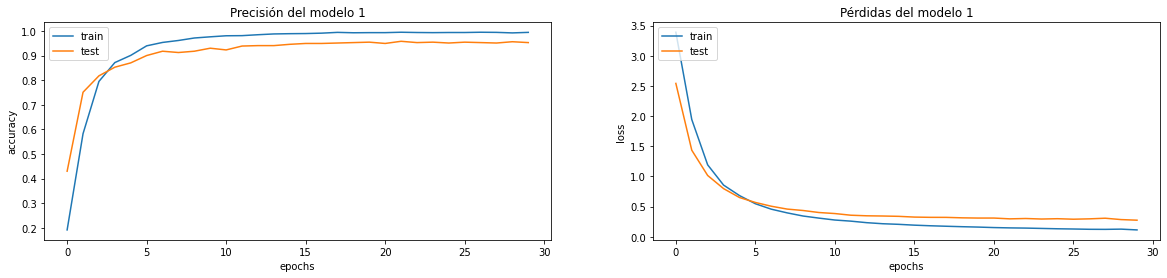

In [ ]:
# Imprimir los datos de la topología 1 del Auto-Encoder con clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_class.history['accuracy'])
plt.plot(result1_class.history['val_accuracy'])
plt.title('Precisión del modelo 1')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_class.history['loss'])
plt.plot(result1_class.history['val_loss'])
plt.title('Pérdidas del modelo 1')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.2 Topología 2: Auto-encoder
> Se diseña con 2 capas de codificación y decodificación. En cada capa se busca reducir el tamaño = tamaño/3.

In [ ]:
first_encoding_dim = 2688
second_encoding_dim = 896
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='relu')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='relu')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='relu')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='relu')(decoded_second)

In [ ]:
full_autoencoder_t2 = keras.Model(input_img, decoded_first)
full_autoencoder_t2.summary() # Construcción del Autoencoder 2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense (Dense)               (None, 2688)              21678720  
                                                                 
 dense_1 (Dense)             (None, 896)               2409344   
                                                                 
 dense_2 (Dense)             (None, 2688)              2411136   
                                                                 
 dense_3 (Dense)             (None, 8064)              21684096  
                                                                 
Total params: 48,183,296
Trainable params: 48,183,296
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result2 = full_autoencoder_t2.fit(x_train, x_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
95/95 [==============================] - 42s 435ms/step - loss: 0.1215 - accuracy: 0.0011 - val_loss: 0.0150 - val_accuracy: 0.0000e+00
Epoch 2/30
95/95 [==============================] - 40s 417ms/step - loss: 0.0138 - accuracy: 0.0011 - val_loss: 0.0134 - val_accuracy: 0.0035
Epoch 3/30
95/95 [==============================] - 41s 427ms/step - loss: 0.0115 - accuracy: 0.0027 - val_loss: 0.0111 - val_accuracy: 0.0018
Epoch 4/30
95/95 [==============================] - 40s 418ms/step - loss: 0.0100 - accuracy: 0.0016 - val_loss: 0.0134 - val_accuracy: 0.0018
Epoch 5/30
95/95 [==============================] - 39s 410ms/step - loss: 0.0091 - accuracy: 0.0032 - val_loss: 0.0079 - val_accuracy: 0.0140
Epoch 6/30
95/95 [==============================] - 41s 430ms/step - loss: 0.0073 - accuracy: 0.0058 - val_loss: 0.0077 - val_accuracy: 0.0105
Epoch 7/30
95/95 [==============================] - 40s 419ms/step - loss: 0.0067 - accuracy: 0.0058 - val_loss: 0.0073 - val_accuracy: 0.

In [ ]:
decoded_imgs = full_autoencoder_t2.predict(x_test)
full_autoencoder_t2.save(path + 'encoder_t2.h5')

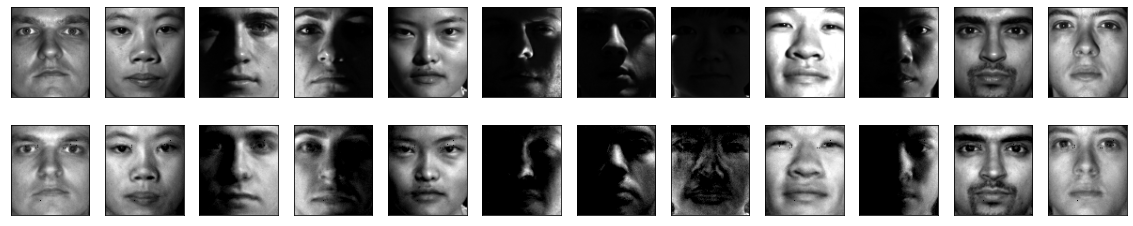

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Cargando modelo del encoder 2
encoder2 = keras.models.load_model(path + 'encoder_t2.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder2.get_layer('dense_1').get_output_at(node_index=0))
class_Auto = keras.Model(encoder2.get_layer('input_1').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result2_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 15s 152ms/step - loss: 3.5244 - accuracy: 0.1722 - val_loss: 2.7691 - val_accuracy: 0.3596
Epoch 2/30
95/95 [==============================] - 16s 172ms/step - loss: 2.2727 - accuracy: 0.5138 - val_loss: 1.8248 - val_accuracy: 0.6070
Epoch 3/30
95/95 [==============================] - 16s 165ms/step - loss: 1.5124 - accuracy: 0.7333 - val_loss: 1.2917 - val_accuracy: 0.7667
Epoch 4/30
95/95 [==============================] - 16s 172ms/step - loss: 1.0985 - accuracy: 0.8305 - val_loss: 1.0168 - val_accuracy: 0.8456
Epoch 5/30
95/95 [==============================] - 16s 169ms/step - loss: 0.8737 - accuracy: 0.8804 - val_loss: 0.8244 - val_accuracy: 0.8825
Epoch 6/30
95/95 [==============================] - 16s 163ms/step - loss: 0.7006 - accuracy: 0.9261 - val_loss: 0.7194 - val_accuracy: 0.8842
Epoch 7/30
95/95 [==============================] - 15s 163ms/step - loss: 0.5970 - accuracy: 0.9400 - val_loss: 0.6356 - val_accuracy: 0.8982

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 1s 49ms/step - loss: 0.3191 - accuracy: 0.9526


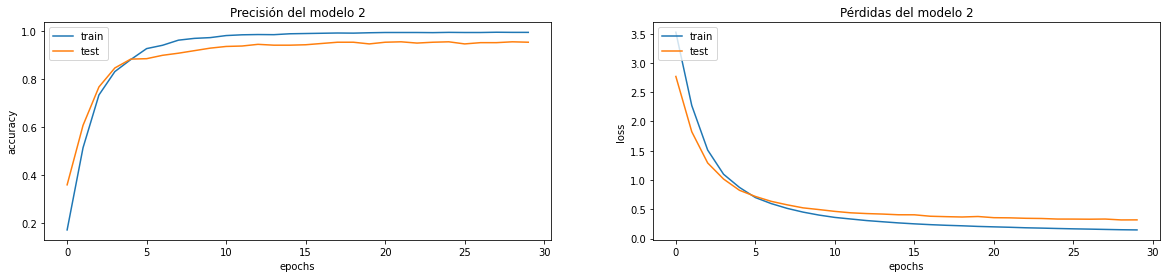

In [ ]:
# Imprimir los datos de la topología 2 del Auto-Encoder con clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result2_class.history['accuracy'])
plt.plot(result2_class.history['val_accuracy'])
plt.title('Precisión del modelo 2')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result2_class.history['loss'])
plt.plot(result2_class.history['val_loss'])
plt.title('Pérdidas del modelo 2')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.3 Topología 3: Auto-encoder
> Se diseña con 4 capas de codificación y decodificación. En cada capa se busca reducir el tamaño a la mitad.

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
third_encoding_dim = 1008
fourth_encoding_dim = 504

input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='relu')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='relu')(encoded_first)
encoded_third = layers.Dense(units=third_encoding_dim, activation='relu')(encoded_second)
encoded_fourth = layers.Dense(units=fourth_encoding_dim, activation='relu')(encoded_third)
decoded_fourth = layers.Dense(units=third_encoding_dim, activation='relu')(encoded_fourth)
decoded_third = layers.Dense(units=second_encoding_dim, activation='relu')(decoded_fourth)
decoded_second = layers.Dense(units=first_encoding_dim, activation='relu')(decoded_third)
decoded_first = layers.Dense(units=(96*84), activation='relu')(decoded_second)

In [ ]:
full_autoencoder_t3 = keras.Model(input_img, decoded_first)
full_autoencoder_t3.summary() # Construcción del Autoencoder 3

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_4 (Dense)             (None, 4032)              32518080  
                                                                 
 dense_5 (Dense)             (None, 2016)              8130528   
                                                                 
 dense_6 (Dense)             (None, 1008)              2033136   
                                                                 
 dense_7 (Dense)             (None, 504)               508536    
                                                                 
 dense_8 (Dense)             (None, 1008)              509040    
                                                                 
 dense_9 (Dense)             (None, 2016)              2034

In [ ]:
full_autoencoder_t3.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result3 = full_autoencoder_t3.fit(x_train, x_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
95/95 [==============================] - 74s 774ms/step - loss: 0.1107 - accuracy: 5.3135e-04 - val_loss: 0.0223 - val_accuracy: 0.0035
Epoch 2/30
95/95 [==============================] - 75s 787ms/step - loss: 0.0200 - accuracy: 0.0000e+00 - val_loss: 0.0220 - val_accuracy: 0.0035
Epoch 3/30
95/95 [==============================] - 70s 741ms/step - loss: 0.0193 - accuracy: 0.0016 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 4/30
95/95 [==============================] - 70s 733ms/step - loss: 0.0184 - accuracy: 0.0016 - val_loss: 0.0182 - val_accuracy: 0.0018
Epoch 5/30
95/95 [==============================] - 70s 738ms/step - loss: 0.0175 - accuracy: 0.0021 - val_loss: 0.0181 - val_accuracy: 0.0000e+00
Epoch 6/30
95/95 [==============================] - 71s 749ms/step - loss: 0.0171 - accuracy: 0.0021 - val_loss: 0.0186 - val_accuracy: 0.0018
Epoch 7/30
95/95 [==============================] - 74s 774ms/step - loss: 0.0164 - accuracy: 0.0027 - val_loss: 0.0146 - val_

In [ ]:
decoded_imgs = full_autoencoder_t3.predict(x_test)
full_autoencoder_t3.save(path + 'encoder_t3.h5')

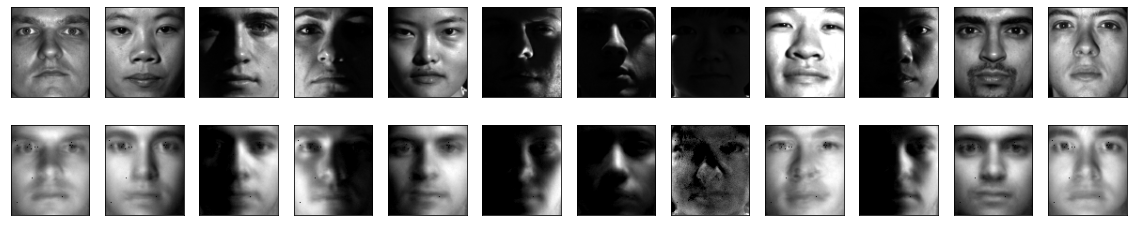

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Cargando modelo del encoder 3
encoder3 = keras.models.load_model(path + 'encoder_t3.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder3.get_layer('dense_7').get_output_at(node_index=0))
class_Auto = keras.Model(encoder3.get_layer('input_2').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result3_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 28s 286ms/step - loss: 3.9709 - accuracy: 0.0452 - val_loss: 3.6249 - val_accuracy: 0.0772
Epoch 2/30
95/95 [==============================] - 30s 317ms/step - loss: 3.3271 - accuracy: 0.1079 - val_loss: 3.0403 - val_accuracy: 0.1368
Epoch 3/30
95/95 [==============================] - 29s 307ms/step - loss: 2.7949 - accuracy: 0.2078 - val_loss: 2.6184 - val_accuracy: 0.2298
Epoch 4/30
95/95 [==============================] - 31s 324ms/step - loss: 2.3042 - accuracy: 0.3241 - val_loss: 2.1155 - val_accuracy: 0.3702
Epoch 5/30
95/95 [==============================] - 30s 318ms/step - loss: 1.8409 - accuracy: 0.4469 - val_loss: 1.6921 - val_accuracy: 0.5018
Epoch 6/30
95/95 [==============================] - 30s 316ms/step - loss: 1.4320 - accuracy: 0.5962 - val_loss: 1.4027 - val_accuracy: 0.5702
Epoch 7/30
95/95 [==============================] - 29s 310ms/step - loss: 1.1387 - accuracy: 0.6934 - val_loss: 1.1456 - val_accuracy: 0.6877

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 1s 81ms/step - loss: 0.3823 - accuracy: 0.9351


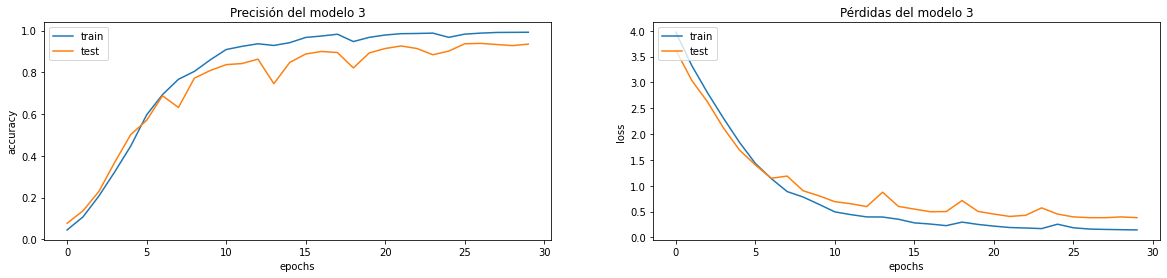

In [ ]:
# Imprimir los datos de la topología 3 del Auto-Encoder con clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result3_class.history['accuracy'])
plt.plot(result3_class.history['val_accuracy'])
plt.title('Precisión del modelo 3')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result3_class.history['loss'])
plt.plot(result3_class.history['val_loss'])
plt.title('Pérdidas del modelo 3')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5. Análisis de sensibilidad

Con el fin de cumplir con los objetivos planteado al inicio de este miproyecto. A continuación se plantean diferentes cambios en batch, funciones de activación, mecanismos de regularización y optimización, para la topologia del auto-encoder.

### 5.1 Tamaños del Batch
> Se realizarán variaciones con 3 tamaños de batch: a 50, 100 y 10. 



#### 5.1.1 Batch 1 = 50


In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='relu')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='relu')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='relu')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='relu')(decoded_second)

In [ ]:
full_autoencoder_t1_b1 = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1.summary() # Construcción del Autoencoder 1 con batch 1

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_26 (Dense)            (None, 4032)              32518080  
                                                                 
 dense_27 (Dense)            (None, 2016)              8130528   
                                                                 
 dense_28 (Dense)            (None, 4032)              8132544   
                                                                 
 dense_29 (Dense)            (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1_b1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b1 = full_autoencoder_t1_b1.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 37s 942ms/step - loss: 1.0311 - accuracy: 0.0000e+00 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 2/30
38/38 [==============================] - 46s 1s/step - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 3/30
38/38 [==============================] - 40s 1s/step - loss: 0.0148 - accuracy: 0.0016 - val_loss: 0.0145 - val_accuracy: 0.0053
Epoch 4/30
38/38 [==============================] - 39s 1s/step - loss: 0.0134 - accuracy: 0.0021 - val_loss: 0.0131 - val_accuracy: 0.0000e+00
Epoch 5/30
38/38 [==============================] - 38s 999ms/step - loss: 0.0121 - accuracy: 0.0021 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 6/30
38/38 [==============================] - 41s 1s/step - loss: 0.0110 - accuracy: 0.0021 - val_loss: 0.0114 - val_accuracy: 0.0088
Epoch 7/30
38/38 [==============================] - 35s 924ms/step - loss: 0.0103 - accuracy: 0.0032 - val_loss: 0.0098 - val_accu

In [ ]:
decoded_imgs = full_autoencoder_t1_b1.predict(x_test)
full_autoencoder_t1_b1.save(path + 'encoder_t1_b1.h5')

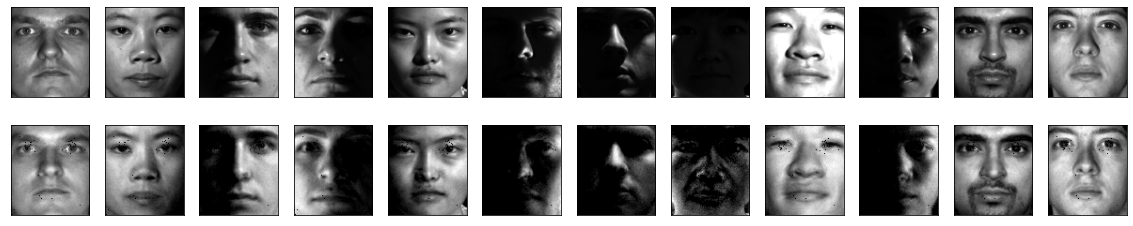

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Cargando modelo del encoder 1 con batch 1
encoder1_b1 = keras.models.load_model(path + 'encoder_t1_b1.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1.get_layer('dense_27').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1.get_layer('input_3').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b1_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 28s 285ms/step - loss: 3.4714 - accuracy: 0.1684 - val_loss: 2.7167 - val_accuracy: 0.3614
Epoch 2/30
95/95 [==============================] - 28s 293ms/step - loss: 2.1850 - accuracy: 0.4931 - val_loss: 1.7626 - val_accuracy: 0.6158
Epoch 3/30
95/95 [==============================] - 27s 288ms/step - loss: 1.4003 - accuracy: 0.7274 - val_loss: 1.2189 - val_accuracy: 0.7333
Epoch 4/30
95/95 [==============================] - 30s 313ms/step - loss: 0.9686 - accuracy: 0.8348 - val_loss: 0.8586 - val_accuracy: 0.8474
Epoch 5/30
95/95 [==============================] - 29s 308ms/step - loss: 0.7231 - accuracy: 0.8932 - val_loss: 0.7241 - val_accuracy: 0.8456
Epoch 6/30
95/95 [==============================] - 28s 296ms/step - loss: 0.5809 - accuracy: 0.9192 - val_loss: 0.5890 - val_accuracy: 0.8965
Epoch 7/30
95/95 [==============================] - 29s 307ms/step - loss: 0.4548 - accuracy: 0.9538 - val_loss: 0.5255 - val_accuracy: 0.9158

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 97ms/step - loss: 0.2859 - accuracy: 0.9579


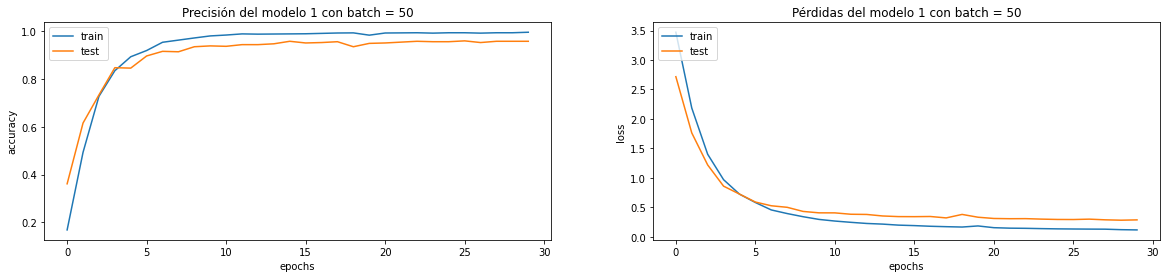

In [ ]:
# Imprimir los datos de la topología 1 con batch 1 del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_class.history['accuracy'])
plt.plot(result1_b1_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con batch = 50')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_class.history['loss'])
plt.plot(result1_b1_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con batch = 50')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5.1.1 Batch 2 = 100

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='relu')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='relu')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='relu')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='relu')(decoded_second)

In [ ]:
full_autoencoder_t1_b2 = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b2.summary() # Construcción del Autoencoder 1 con batch 2

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_6 (Dense)             (None, 4032)              32518080  
                                                                 
 dense_7 (Dense)             (None, 2016)              8130528   
                                                                 
 dense_8 (Dense)             (None, 4032)              8132544   
                                                                 
 dense_9 (Dense)             (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1_b2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b2 = full_autoencoder_t1_b2.fit(x_train, x_train, epochs=30, batch_size=100, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
19/19 [==============================] - 28s 1s/step - loss: 0.0244 - accuracy: 5.3135e-04 - val_loss: 0.0210 - val_accuracy: 0.0000e+00
Epoch 2/30
19/19 [==============================] - 28s 1s/step - loss: 0.0198 - accuracy: 5.3135e-04 - val_loss: 0.0190 - val_accuracy: 0.0000e+00
Epoch 3/30
19/19 [==============================] - 27s 1s/step - loss: 0.0173 - accuracy: 5.3135e-04 - val_loss: 0.0163 - val_accuracy: 0.0018
Epoch 4/30
19/19 [==============================] - 31s 2s/step - loss: 0.0149 - accuracy: 0.0000e+00 - val_loss: 0.0144 - val_accuracy: 0.0018
Epoch 5/30
19/19 [==============================] - 26s 1s/step - loss: 0.0139 - accuracy: 0.0032 - val_loss: 0.0139 - val_accuracy: 0.0018
Epoch 6/30
19/19 [==============================] - 28s 1s/step - loss: 0.0135 - accuracy: 0.0027 - val_loss: 0.0136 - val_accuracy: 0.0035
Epoch 7/30
19/19 [==============================] - 26s 1s/step - loss: 0.0131 - accuracy: 0.0037 - val_loss: 0.0130 - val_accuracy: 0.0

In [ ]:
decoded_imgs = full_autoencoder_t1_b2.predict(x_test)
full_autoencoder_t1_b2.save(path + 'encoder_t1_b2.h5')

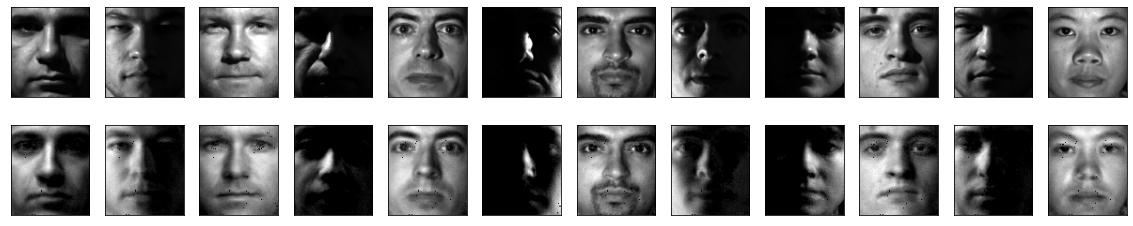

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#Cargando modelo del encoder 1 con batch 2
encoder1_b2 = keras.models.load_model(path + 'encoder_t1_b2.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b2.get_layer('dense_7').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b2.get_layer('input_2').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b2_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 30s 315ms/step - loss: 3.6046 - accuracy: 0.1243 - val_loss: 3.0311 - val_accuracy: 0.2281
Epoch 2/30
95/95 [==============================] - 29s 308ms/step - loss: 2.5130 - accuracy: 0.3911 - val_loss: 2.0439 - val_accuracy: 0.5386
Epoch 3/30
95/95 [==============================] - 29s 308ms/step - loss: 1.6677 - accuracy: 0.6456 - val_loss: 1.3038 - val_accuracy: 0.7912
Epoch 4/30
95/95 [==============================] - 30s 311ms/step - loss: 1.1107 - accuracy: 0.7997 - val_loss: 0.9691 - val_accuracy: 0.8175
Epoch 5/30
95/95 [==============================] - 29s 309ms/step - loss: 0.8019 - accuracy: 0.8794 - val_loss: 0.7751 - val_accuracy: 0.8316
Epoch 6/30
95/95 [==============================] - 29s 310ms/step - loss: 0.6207 - accuracy: 0.9192 - val_loss: 0.6216 - val_accuracy: 0.8789
Epoch 7/30
95/95 [==============================] - 29s 307ms/step - loss: 0.4836 - accuracy: 0.9495 - val_loss: 0.5650 - val_accuracy: 0.9053

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 85ms/step - loss: 0.2815 - accuracy: 0.9544


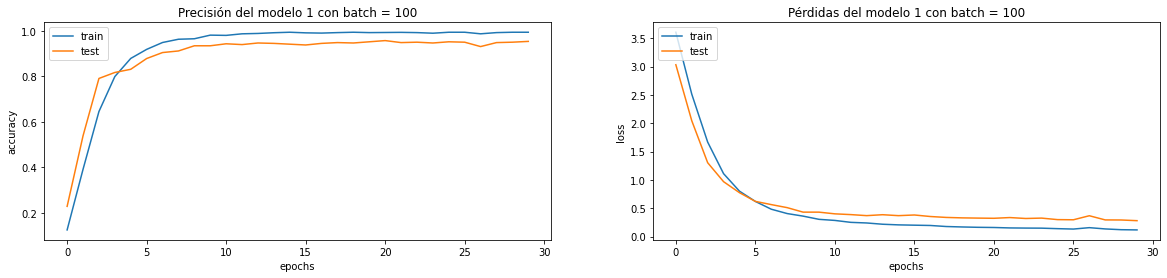

In [ ]:
# Imprimir los datos de la topología 1 con batch 2 del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b2_class.history['accuracy'])
plt.plot(result1_b2_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con batch = 100')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b2_class.history['loss'])
plt.plot(result1_b2_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con batch = 100')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5.1.1 Batch 3 = 10

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='relu')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='relu')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='relu')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='relu')(decoded_second)

In [ ]:
full_autoencoder_t1_b3 = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b3.summary() # Construcción del Autoencoder 1 con batch 3

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense (Dense)               (None, 4032)              32518080  
                                                                 
 dense_1 (Dense)             (None, 2016)              8130528   
                                                                 
 dense_2 (Dense)             (None, 4032)              8132544   
                                                                 
 dense_3 (Dense)             (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1_b3.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b3 = full_autoencoder_t1_b3.fit(x_train, x_train, epochs=30, batch_size=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
189/189 [==============================] - 99s 518ms/step - loss: 0.1609 - accuracy: 0.0000e+00 - val_loss: 0.0212 - val_accuracy: 0.0035
Epoch 2/30
189/189 [==============================] - 96s 507ms/step - loss: 0.0160 - accuracy: 0.0021 - val_loss: 0.0156 - val_accuracy: 0.0018
Epoch 3/30
189/189 [==============================] - 95s 504ms/step - loss: 0.0135 - accuracy: 0.0048 - val_loss: 0.0131 - val_accuracy: 0.0088
Epoch 4/30
189/189 [==============================] - 97s 514ms/step - loss: 0.0119 - accuracy: 0.0032 - val_loss: 0.0113 - val_accuracy: 0.0070
Epoch 5/30
189/189 [==============================] - 99s 522ms/step - loss: 0.0107 - accuracy: 0.0074 - val_loss: 0.0105 - val_accuracy: 0.0018
Epoch 6/30
189/189 [==============================] - 98s 519ms/step - loss: 0.0093 - accuracy: 0.0021 - val_loss: 0.0091 - val_accuracy: 0.0105
Epoch 7/30
189/189 [==============================] - 113s 599ms/step - loss: 0.0083 - accuracy: 0.0074 - val_loss: 0.0095 - v

In [ ]:
decoded_imgs = full_autoencoder_t1_b3.predict(x_test)
full_autoencoder_t1_b3.save(path + 'encoder_t1_b3.h5')

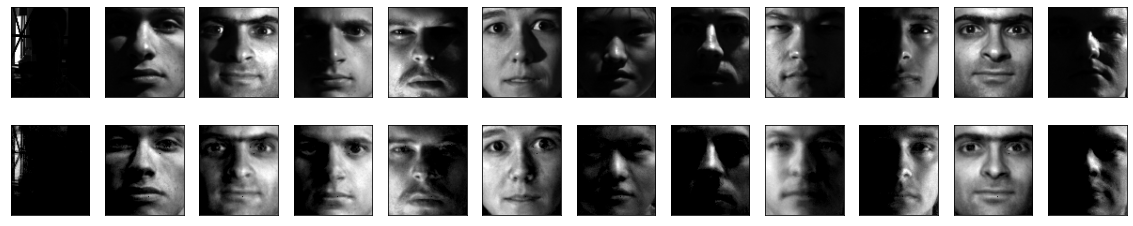

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Cargando modelo del encoder 1 con batch 3
encoder1_b3 = keras.models.load_model(path + 'encoder_t1_b3.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b3.get_layer('dense_1').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b3.get_layer('input_1').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b3_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 25s 255ms/step - loss: 3.5385 - accuracy: 0.1451 - val_loss: 2.9079 - val_accuracy: 0.2614
Epoch 2/30
95/95 [==============================] - 23s 240ms/step - loss: 2.3138 - accuracy: 0.4809 - val_loss: 1.8345 - val_accuracy: 0.5947
Epoch 3/30
95/95 [==============================] - 23s 242ms/step - loss: 1.4837 - accuracy: 0.7205 - val_loss: 1.2682 - val_accuracy: 0.7491
Epoch 4/30
95/95 [==============================] - 23s 240ms/step - loss: 1.0703 - accuracy: 0.8114 - val_loss: 0.9608 - val_accuracy: 0.8228
Epoch 5/30
95/95 [==============================] - 23s 240ms/step - loss: 0.8314 - accuracy: 0.8650 - val_loss: 0.8616 - val_accuracy: 0.8053
Epoch 6/30
95/95 [==============================] - 23s 242ms/step - loss: 0.6805 - accuracy: 0.8905 - val_loss: 0.6858 - val_accuracy: 0.8737
Epoch 7/30
95/95 [==============================] - 23s 241ms/step - loss: 0.5617 - accuracy: 0.9272 - val_loss: 0.6038 - val_accuracy: 0.8807

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 1s 78ms/step - loss: 0.2888 - accuracy: 0.9561


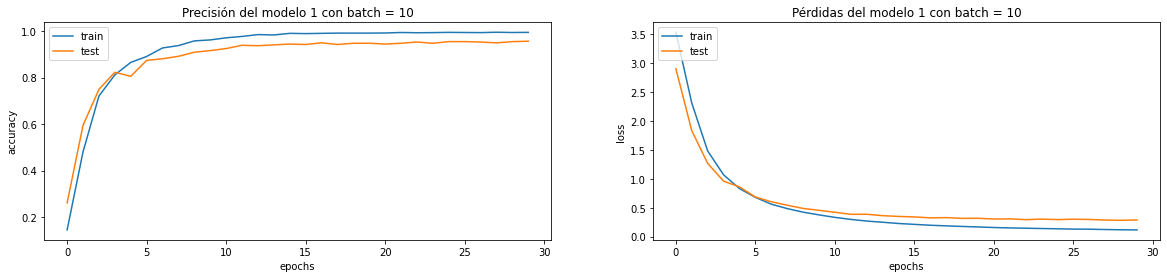

In [ ]:
# Imprimir los datos de la topología 1 con batch 3 del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b3_class.history['accuracy'])
plt.plot(result1_b3_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con batch = 10')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b3_class.history['loss'])
plt.plot(result1_b3_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con batch = 10')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.2 Funciones de activación
> Se presenta la red del auto-encoder con variaciones en las funciones de activación. Ya se presentó el análisis con la función de activación Relu, asi que a continuación se presenta el desarrollo con la función de activación Tanh y Sigmoid.



#### 5.2.1 Activación Tanh

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='tanh')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='tanh')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='tanh')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='tanh')(decoded_second)

In [ ]:
full_autoencoder_t1_b1_f1 = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1_f1.summary() # Construcción del Autoencoder 1 con batch = 50 y activación Tanh

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_5 (Dense)             (None, 4032)              32518080  
                                                                 
 dense_6 (Dense)             (None, 2016)              8130528   
                                                                 
 dense_7 (Dense)             (None, 4032)              8132544   
                                                                 
 dense_8 (Dense)             (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1_b1_f1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b1_f1 = full_autoencoder_t1_b1_f1.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 33s 858ms/step - loss: 0.4945 - accuracy: 0.0000e+00 - val_loss: 0.4278 - val_accuracy: 0.0000e+00
Epoch 2/30
38/38 [==============================] - 36s 944ms/step - loss: 0.4232 - accuracy: 5.3135e-04 - val_loss: 0.4126 - val_accuracy: 0.0000e+00
Epoch 3/30
38/38 [==============================] - 39s 1s/step - loss: 0.4085 - accuracy: 5.3135e-04 - val_loss: 0.4054 - val_accuracy: 0.0000e+00
Epoch 4/30
38/38 [==============================] - 31s 809ms/step - loss: 0.4094 - accuracy: 5.3135e-04 - val_loss: 0.4018 - val_accuracy: 0.0000e+00
Epoch 5/30
38/38 [==============================] - 31s 808ms/step - loss: 0.4076 - accuracy: 5.3135e-04 - val_loss: 0.4014 - val_accuracy: 0.0000e+00
Epoch 6/30
38/38 [==============================] - 35s 938ms/step - loss: 0.4089 - accuracy: 5.3135e-04 - val_loss: 0.4045 - val_accuracy: 0.0000e+00
Epoch 7/30
38/38 [==============================] - 31s 825ms/step - loss: 0.4111 - accuracy: 5.3

In [ ]:
decoded_imgs = full_autoencoder_t1_b1_f1.predict(x_test)
full_autoencoder_t1_b1_f1.save(path + 'encoder_t1_b1_f1.h5')

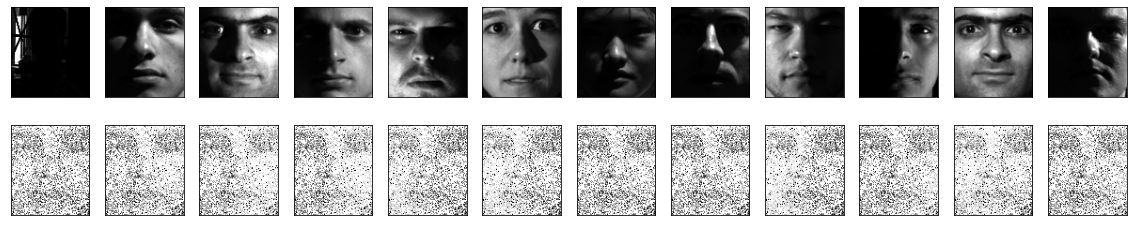

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Cargando modelo del encoder 1 con batch = 50 y activación Tanh
encoder1_b1_f1 = keras.models.load_model(path + 'encoder_t1_b1_f1.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1_f1.get_layer('dense_6').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1_f1.get_layer('input_2').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b1_f1_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 24s 243ms/step - loss: 4.7455 - accuracy: 0.0239 - val_loss: 4.5276 - val_accuracy: 0.0263
Epoch 2/30
95/95 [==============================] - 23s 242ms/step - loss: 4.5602 - accuracy: 0.0202 - val_loss: 4.5107 - val_accuracy: 0.0263
Epoch 3/30
95/95 [==============================] - 23s 240ms/step - loss: 4.5092 - accuracy: 0.0239 - val_loss: 4.5110 - val_accuracy: 0.0263
Epoch 4/30
95/95 [==============================] - 23s 242ms/step - loss: 4.4715 - accuracy: 0.0213 - val_loss: 4.5030 - val_accuracy: 0.0246
Epoch 5/30
95/95 [==============================] - 23s 241ms/step - loss: 4.4458 - accuracy: 0.0292 - val_loss: 4.3961 - val_accuracy: 0.0263
Epoch 6/30
95/95 [==============================] - 23s 240ms/step - loss: 4.3736 - accuracy: 0.0329 - val_loss: 4.3502 - val_accuracy: 0.0368
Epoch 7/30
95/95 [==============================] - 23s 240ms/step - loss: 4.2402 - accuracy: 0.0733 - val_loss: 4.1264 - val_accuracy: 0.1018

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 1s 77ms/step - loss: 0.4041 - accuracy: 0.9649


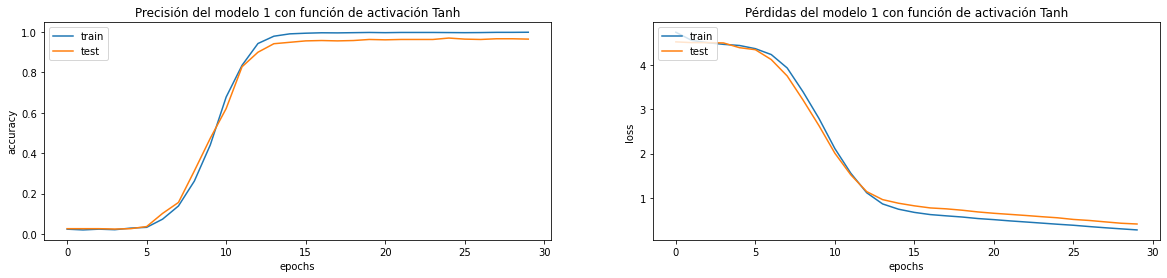

In [ ]:
# Imprimir los datos de la topología 1 con batch 1 y activación Tanh del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_f1_class.history['accuracy'])
plt.plot(result1_b1_f1_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con función de activación Tanh')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_f1_class.history['loss'])
plt.plot(result1_b1_f1_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con función de activación Tanh')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5.2.2 Activación Sigmoid

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='sigmoid')(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='sigmoid')(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='sigmoid')(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='sigmoid')(decoded_second)

In [ ]:
full_autoencoder_t1_b1_f2 = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1_f2.summary() # Construcción del Autoencoder 1 con batch = 50 y función de activación sigmoid

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_10 (Dense)            (None, 4032)              32518080  
                                                                 
 dense_11 (Dense)            (None, 2016)              8130528   
                                                                 
 dense_12 (Dense)            (None, 4032)              8132544   
                                                                 
 dense_13 (Dense)            (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1_b1_f2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b1_f2 = full_autoencoder_t1_b1_f2.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 40s 1s/step - loss: 0.0507 - accuracy: 0.0000e+00 - val_loss: 0.0395 - val_accuracy: 0.0018
Epoch 2/30
38/38 [==============================] - 39s 1s/step - loss: 0.0336 - accuracy: 0.0011 - val_loss: 0.0199 - val_accuracy: 0.0000e+00
Epoch 3/30
38/38 [==============================] - 32s 844ms/step - loss: 0.0183 - accuracy: 5.3135e-04 - val_loss: 0.0163 - val_accuracy: 0.0035
Epoch 4/30
38/38 [==============================] - 36s 963ms/step - loss: 0.0156 - accuracy: 5.3135e-04 - val_loss: 0.0154 - val_accuracy: 0.0035
Epoch 5/30
38/38 [==============================] - 32s 831ms/step - loss: 0.0148 - accuracy: 5.3135e-04 - val_loss: 0.0132 - val_accuracy: 0.0053
Epoch 6/30
38/38 [==============================] - 33s 862ms/step - loss: 0.0122 - accuracy: 0.0037 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 7/30
38/38 [==============================] - 35s 939ms/step - loss: 0.0116 - accuracy: 0.0016 - val_loss: 0.0120 - va

In [ ]:
decoded_imgs = full_autoencoder_t1_b1_f2.predict(x_test)
full_autoencoder_t1_b1_f2.save(path + 'encoder_t1_b1_f2.h5')

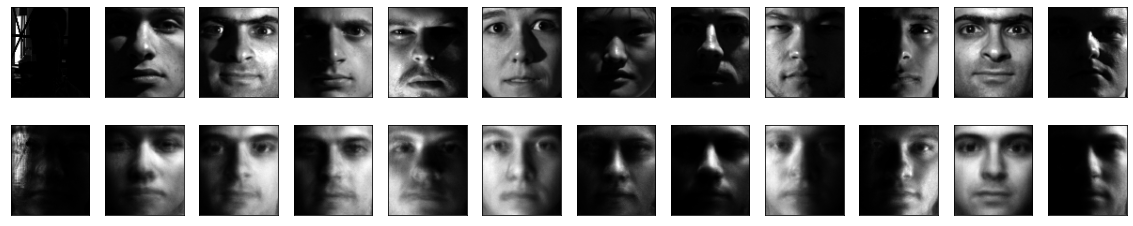

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Cargando modelo del encoder 1 con batch = 50 y función de activación sigmoid
encoder1_b1_f2 = keras.models.load_model(path + 'encoder_t1_b1_f2.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1_f2.get_layer('dense_11').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1_f2.get_layer('input_3').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b1_f2_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 29s 290ms/step - loss: 4.0576 - accuracy: 0.0855 - val_loss: 3.6085 - val_accuracy: 0.1561
Epoch 2/30
95/95 [==============================] - 25s 266ms/step - loss: 3.2854 - accuracy: 0.2322 - val_loss: 2.9727 - val_accuracy: 0.3333
Epoch 3/30
95/95 [==============================] - 27s 284ms/step - loss: 2.6797 - accuracy: 0.4437 - val_loss: 2.4725 - val_accuracy: 0.4860
Epoch 4/30
95/95 [==============================] - 28s 291ms/step - loss: 2.1771 - accuracy: 0.6339 - val_loss: 2.0296 - val_accuracy: 0.6719
Epoch 5/30
95/95 [==============================] - 28s 290ms/step - loss: 1.7439 - accuracy: 0.7752 - val_loss: 1.6378 - val_accuracy: 0.7789
Epoch 6/30
95/95 [==============================] - 28s 290ms/step - loss: 1.3768 - accuracy: 0.8709 - val_loss: 1.3065 - val_accuracy: 0.8667
Epoch 7/30
95/95 [==============================] - 25s 259ms/step - loss: 1.1135 - accuracy: 0.9251 - val_loss: 1.1319 - val_accuracy: 0.8860

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 95ms/step - loss: 0.3986 - accuracy: 0.9649


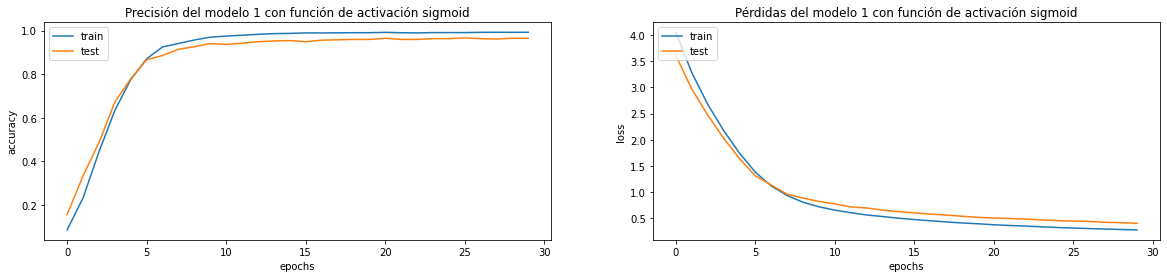

In [ ]:
# Imprimir los datos de la topología 1 con función de activación sigmoid del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_f2_class.history['accuracy'])
plt.plot(result1_b1_f2_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con función de activación sigmoid')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_f2_class.history['loss'])
plt.plot(result1_b1_f2_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con función de activación sigmoid')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.3 Mecanismos de regularización

#### 5.3.1 Regularización L2

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.05))(input_img)
encoded_second = layers.Dense(units=second_encoding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.05))(encoded_first)
decoded_second = layers.Dense(units=first_encoding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.05))(encoded_second)
decoded_first = layers.Dense(units=(96*84), activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.05))(decoded_second)

In [ ]:
full_autoencoder_t1_b1_f2_L2 = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1_f2_L2.summary() # Construcción del Autoencoder con función de activación sigmoid y un mecanismo de regularización L2.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_6 (Dense)             (None, 4032)              32518080  
                                                                 
 dense_7 (Dense)             (None, 2016)              8130528   
                                                                 
 dense_8 (Dense)             (None, 4032)              8132544   
                                                                 
 dense_9 (Dense)             (None, 8064)              32522112  
                                                                 
Total params: 81,303,264
Trainable params: 81,303,264
Non-trainable params: 0
_________________________________________________________________


In [ ]:
full_autoencoder_t1_b1_f2_L2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b1_f2_L2 = full_autoencoder_t1_b1_f2_L2.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 49s 1s/step - loss: 158.2054 - accuracy: 5.3135e-04 - val_loss: 7.4409 - val_accuracy: 0.0000e+00
Epoch 2/30
38/38 [==============================] - 50s 1s/step - loss: 2.0326 - accuracy: 0.0016 - val_loss: 0.2290 - val_accuracy: 0.0000e+00
Epoch 3/30
38/38 [==============================] - 50s 1s/step - loss: 0.1345 - accuracy: 0.0011 - val_loss: 0.0977 - val_accuracy: 0.0000e+00
Epoch 4/30
38/38 [==============================] - 49s 1s/step - loss: 0.0974 - accuracy: 0.0000e+00 - val_loss: 0.0925 - val_accuracy: 0.0000e+00
Epoch 5/30
38/38 [==============================] - 50s 1s/step - loss: 0.0939 - accuracy: 5.3135e-04 - val_loss: 0.0897 - val_accuracy: 0.0000e+00
Epoch 6/30
38/38 [==============================] - 49s 1s/step - loss: 0.0911 - accuracy: 5.3135e-04 - val_loss: 0.0870 - val_accuracy: 0.0000e+00
Epoch 7/30
38/38 [==============================] - 51s 1s/step - loss: 0.0885 - accuracy: 0.0000e+00 - val_loss: 0.08

In [ ]:
decoded_imgs = full_autoencoder_t1_b1_f2_L2.predict(x_test)
full_autoencoder_t1_b1_f2_L2.save(path + 'encoder_t1_b1_f2_L2.h5')

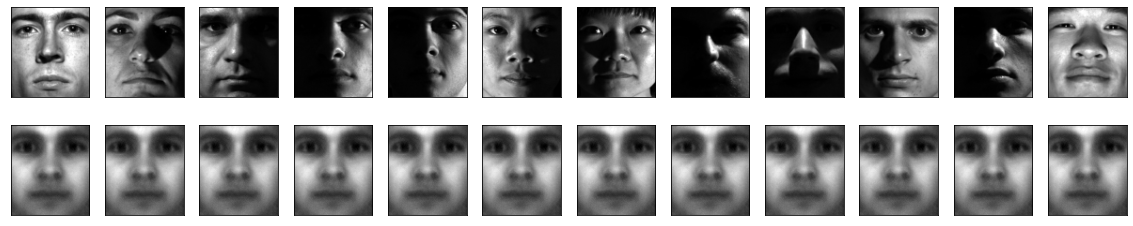

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Cargando modelo del encoder 1 con batch = 50, función de activación sigmoid y mecanismo de regularización L2
encoder1_b1_f2_L2 = keras.models.load_model(path + 'encoder_t1_b1_f2_L2.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1_f2_L2.get_layer('dense_7').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1_f2_L2.get_layer('input_2').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b1_f2_L2_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 45s 463ms/step - loss: 5.4657 - accuracy: 0.0218 - val_loss: 4.9084 - val_accuracy: 0.0263
Epoch 2/30
95/95 [==============================] - 44s 461ms/step - loss: 4.8411 - accuracy: 0.0260 - val_loss: 4.8738 - val_accuracy: 0.0263
Epoch 3/30
95/95 [==============================] - 45s 472ms/step - loss: 4.7624 - accuracy: 0.0308 - val_loss: 4.7430 - val_accuracy: 0.0263
Epoch 4/30
95/95 [==============================] - 48s 508ms/step - loss: 4.6238 - accuracy: 0.0276 - val_loss: 4.7311 - val_accuracy: 0.0263
Epoch 5/30
95/95 [==============================] - 51s 540ms/step - loss: 4.5877 - accuracy: 0.0287 - val_loss: 4.5889 - val_accuracy: 0.0263
Epoch 6/30
95/95 [==============================] - 47s 499ms/step - loss: 4.5520 - accuracy: 0.0228 - val_loss: 4.4099 - val_accuracy: 0.0263
Epoch 7/30
95/95 [==============================] - 48s 503ms/step - loss: 4.4534 - accuracy: 0.0244 - val_loss: 4.4172 - val_accuracy: 0.0263

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 124ms/step - loss: 3.8144 - accuracy: 0.0263


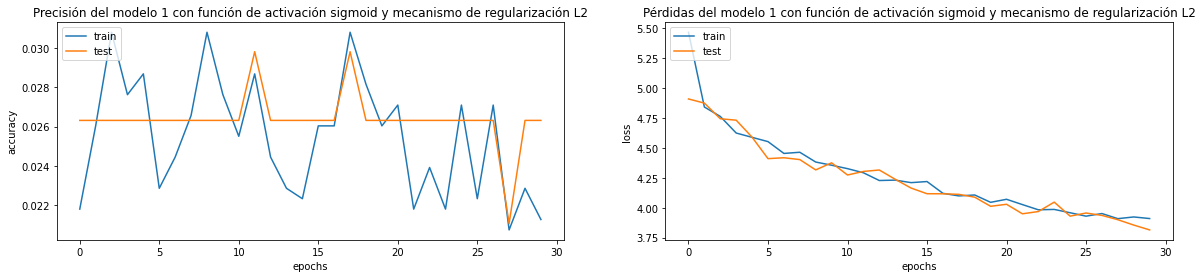

In [ ]:
# Imprimir los datos de la topología 1 con función de activación sigmoid y mecanismo de regularización L2 del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_f2_L2_class.history['accuracy'])
plt.plot(result1_b1_f2_L2_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con función de activación sigmoid y mecanismo de regularización L2')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_f2_L2_class.history['loss'])
plt.plot(result1_b1_f2_L2_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con función de activación sigmoid y mecanismo de regularización L2')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5.3.2 Dropout

In [ ]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='sigmoid')(input_img)
drop1 = layers.Dropout(0.2)(encoded_first)
encoded_second = layers.Dense(units=second_encoding_dim, activation='sigmoid')(drop1)
drop2 = layers.Dropout(0.2)(encoded_second)
decoded_second = layers.Dense(units=first_encoding_dim, activation='sigmoid')(drop2)
drop3 = layers.Dropout(0.2)(decoded_second)
decoded_first = layers.Dense(units=(96*84), activation='sigmoid')(drop3)

In [ ]:
full_autoencoder_t1_b1_f2_dp = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1_f2_dp.summary() # Construcción del Autoencoder con función de activación sigmoid y un mecanismo de regularización dropout.

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_39 (Dense)            (None, 4032)              32518080  
                                                                 
 dropout_19 (Dropout)        (None, 4032)              0         
                                                                 
 dense_40 (Dense)            (None, 2016)              8130528   
                                                                 
 dropout_20 (Dropout)        (None, 2016)              0         
                                                                 
 dense_41 (Dense)            (None, 4032)              8132544   
                                                                 
 dropout_21 (Dropout)        (None, 4032)              0   

In [ ]:
full_autoencoder_t1_b1_f2_dp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
result1_b1_f2_dp = full_autoencoder_t1_b1_f2_dp.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 37s 951ms/step - loss: 0.0526 - accuracy: 5.3135e-04 - val_loss: 0.0406 - val_accuracy: 0.0000e+00
Epoch 2/30
38/38 [==============================] - 38s 989ms/step - loss: 0.0307 - accuracy: 5.3135e-04 - val_loss: 0.0187 - val_accuracy: 0.0000e+00
Epoch 3/30
38/38 [==============================] - 36s 951ms/step - loss: 0.0189 - accuracy: 5.3135e-04 - val_loss: 0.0167 - val_accuracy: 0.0018
Epoch 4/30
38/38 [==============================] - 35s 934ms/step - loss: 0.0165 - accuracy: 0.0021 - val_loss: 0.0156 - val_accuracy: 0.0018
Epoch 5/30
38/38 [==============================] - 35s 927ms/step - loss: 0.0159 - accuracy: 0.0021 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 6/30
38/38 [==============================] - 35s 924ms/step - loss: 0.0151 - accuracy: 0.0021 - val_loss: 0.0150 - val_accuracy: 0.0018
Epoch 7/30
38/38 [==============================] - 34s 908ms/step - loss: 0.0131 - accuracy: 0.0016 - val_loss: 0.012

In [ ]:
decoded_imgs = full_autoencoder_t1_b1_f2_dp.predict(x_test)
full_autoencoder_t1_b1_f2_dp.save(path + 'encoder_t1_b1_f2_dp.h5')

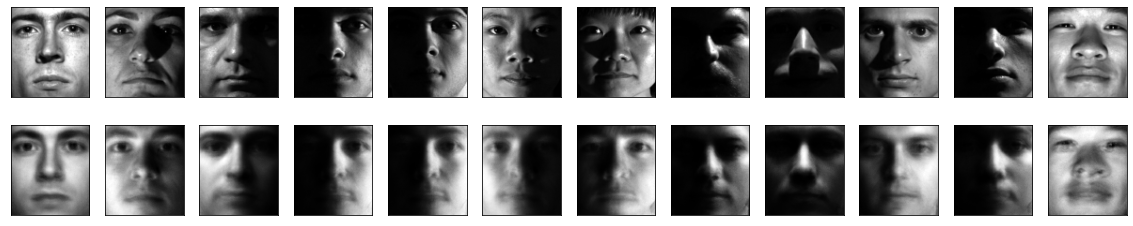

In [ ]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Cargando modelo del encoder 1 con batch = 50, función de activación sigmoid y mecanismo de regularización dropout
encoder1_b1_f2_dp = keras.models.load_model(path + 'encoder_t1_b1_f2_dp.h5')

# Construcción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1_f2_dp.get_layer('dense_40').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1_f2_dp.get_layer('input_5').get_output_at(node_index=0), classAuto)

In [ ]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
result1_b1_f2_dp_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 33s 337ms/step - loss: 4.0634 - accuracy: 0.0733 - val_loss: 3.6368 - val_accuracy: 0.1018
Epoch 2/30
95/95 [==============================] - 26s 279ms/step - loss: 3.3621 - accuracy: 0.1966 - val_loss: 3.1113 - val_accuracy: 0.2456
Epoch 3/30
95/95 [==============================] - 25s 261ms/step - loss: 2.8557 - accuracy: 0.3433 - val_loss: 2.6203 - val_accuracy: 0.4561
Epoch 4/30
95/95 [==============================] - 24s 252ms/step - loss: 2.3776 - accuracy: 0.5218 - val_loss: 2.1827 - val_accuracy: 0.5947
Epoch 5/30
95/95 [==============================] - 27s 280ms/step - loss: 1.9459 - accuracy: 0.6796 - val_loss: 1.7848 - val_accuracy: 0.7298
Epoch 6/30
95/95 [==============================] - 26s 271ms/step - loss: 1.5570 - accuracy: 0.7928 - val_loss: 1.4758 - val_accuracy: 0.8158
Epoch 7/30
95/95 [==============================] - 25s 263ms/step - loss: 1.2597 - accuracy: 0.8688 - val_loss: 1.2010 - val_accuracy: 0.8421

In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 88ms/step - loss: 0.4059 - accuracy: 0.9596


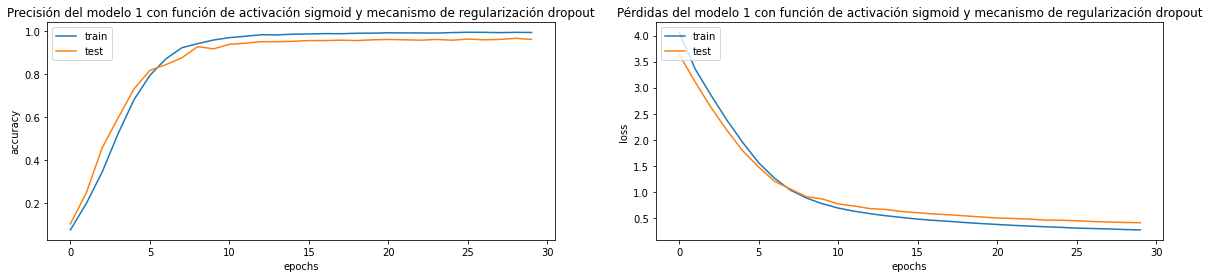

In [ ]:
# Imprimir los datos de la topología 1 con función de activación sigmoid y mecanismo de regularización dropout del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_f2_dp_class.history['accuracy'])
plt.plot(result1_b1_f2_dp_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con función de activación sigmoid y mecanismo de regularización dropout')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_f2_dp_class.history['loss'])
plt.plot(result1_b1_f2_dp_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con función de activación sigmoid y mecanismo de regularización dropout')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5.4 Algoritmos de optimización

Se presenta la implementación de 3 algoritmos de optmización Adam, RMSprop y Ademax. Vale aclarar que Adam se implementó en la topología original.

#### 5.4.1 RMSprop

In [19]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='sigmoid')(input_img)
drop1 = layers.Dropout(0.2)(encoded_first)
encoded_second = layers.Dense(units=second_encoding_dim, activation='sigmoid')(drop1)
drop2 = layers.Dropout(0.2)(encoded_second)
decoded_second = layers.Dense(units=first_encoding_dim, activation='sigmoid')(drop2)
drop3 = layers.Dropout(0.2)(decoded_second)
decoded_first = layers.Dense(units=(96*84), activation='sigmoid')(drop3)

In [20]:
full_autoencoder_t1_b1_f2_dp_rms = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1_f2_dp_rms.summary() # Construcción del Autoencoder con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_5 (Dense)             (None, 4032)              32518080  
                                                                 
 dropout_3 (Dropout)         (None, 4032)              0         
                                                                 
 dense_6 (Dense)             (None, 2016)              8130528   
                                                                 
 dropout_4 (Dropout)         (None, 2016)              0         
                                                                 
 dense_7 (Dense)             (None, 4032)              8132544   
                                                                 
 dropout_5 (Dropout)         (None, 4032)              0   

In [21]:
full_autoencoder_t1_b1_f2_dp_rms.compile(optimizer='RMSprop', loss='mse', metrics=['accuracy'])

In [22]:
result1_b1_f2_dp_rms = full_autoencoder_t1_b1_f2_dp_rms.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 43s 1s/step - loss: 0.0611 - accuracy: 5.3135e-04 - val_loss: 0.0443 - val_accuracy: 0.0018
Epoch 2/30
38/38 [==============================] - 43s 1s/step - loss: 0.0370 - accuracy: 5.3135e-04 - val_loss: 0.0420 - val_accuracy: 0.0000e+00
Epoch 3/30
38/38 [==============================] - 42s 1s/step - loss: 0.0247 - accuracy: 5.3135e-04 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 4/30
38/38 [==============================] - 42s 1s/step - loss: 0.0234 - accuracy: 0.0021 - val_loss: 0.0214 - val_accuracy: 0.0018
Epoch 5/30
38/38 [==============================] - 42s 1s/step - loss: 0.0218 - accuracy: 0.0021 - val_loss: 0.0207 - val_accuracy: 0.0018
Epoch 6/30
38/38 [==============================] - 44s 1s/step - loss: 0.0201 - accuracy: 0.0011 - val_loss: 0.0199 - val_accuracy: 0.0000e+00
Epoch 7/30
38/38 [==============================] - 44s 1s/step - loss: 0.0187 - accuracy: 0.0016 - val_loss: 0.0171 - val_accuracy: 0.0

In [23]:
decoded_imgs = full_autoencoder_t1_b1_f2_dp_rms.predict(x_test)
full_autoencoder_t1_b1_f2_dp_rms.save(path + 'encoder_t1_b1_f2_dp_rms.h5')

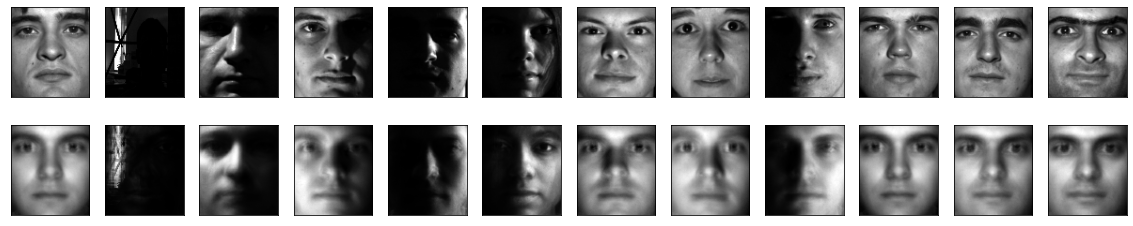

In [24]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
#Cargando modelo del encoder 1 con batch = 50, función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop
encoder1_b1_f2_dp_rms = keras.models.load_model(path + 'encoder_t1_b1_f2_dp_rms.h5')

# Creacción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1_f2_dp_rms.get_layer('dense_6').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1_f2_dp_rms.get_layer('input_2').get_output_at(node_index=0), classAuto)

In [26]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
result1_b1_f2_dp_rms_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 29s 299ms/step - loss: 4.0525 - accuracy: 0.0728 - val_loss: 3.6783 - val_accuracy: 0.0982
Epoch 2/30
95/95 [==============================] - 24s 256ms/step - loss: 3.4679 - accuracy: 0.1722 - val_loss: 3.3181 - val_accuracy: 0.1684
Epoch 3/30
95/95 [==============================] - 25s 259ms/step - loss: 3.0950 - accuracy: 0.2604 - val_loss: 3.0196 - val_accuracy: 0.2263
Epoch 4/30
95/95 [==============================] - 25s 261ms/step - loss: 2.7601 - accuracy: 0.3650 - val_loss: 2.7586 - val_accuracy: 0.3246
Epoch 5/30
95/95 [==============================] - 25s 262ms/step - loss: 2.4502 - accuracy: 0.4713 - val_loss: 2.4368 - val_accuracy: 0.4544
Epoch 6/30
95/95 [==============================] - 26s 269ms/step - loss: 2.1715 - accuracy: 0.5739 - val_loss: 2.1954 - val_accuracy: 0.5193
Epoch 7/30
95/95 [==============================] - 39s 408ms/step - loss: 1.9101 - accuracy: 0.6870 - val_loss: 1.9280 - val_accuracy: 0.6491

In [28]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 2s 83ms/step - loss: 0.5068 - accuracy: 0.9526


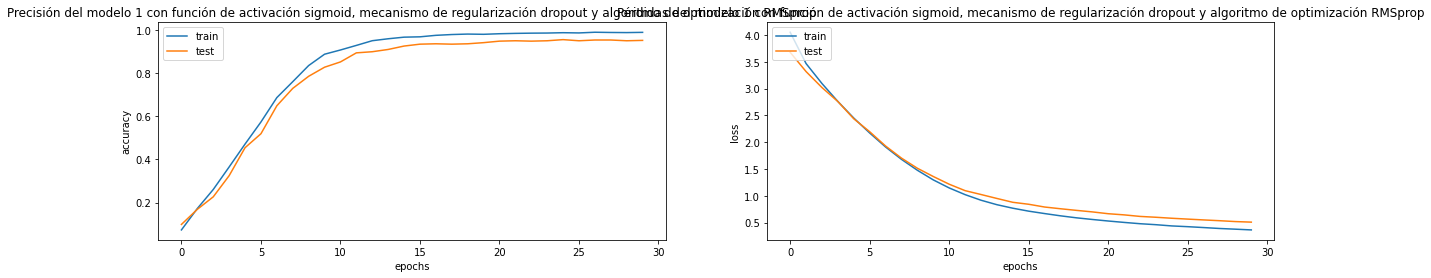

In [29]:
# Imprimir los datos de la topología 1 con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_f2_dp_rms_class.history['accuracy'])
plt.plot(result1_b1_f2_dp_rms_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_f2_dp_rms_class.history['loss'])
plt.plot(result1_b1_f2_dp_rms_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5.4.2 Adamax

In [30]:
first_encoding_dim = 4032
second_encoding_dim = 2016
input_img = keras.Input(shape=(96*84,))
encoded_first = layers.Dense(units=first_encoding_dim, activation='sigmoid')(input_img)
drop1 = layers.Dropout(0.2)(encoded_first)
encoded_second = layers.Dense(units=second_encoding_dim, activation='sigmoid')(drop1)
drop2 = layers.Dropout(0.2)(encoded_second)
decoded_second = layers.Dense(units=first_encoding_dim, activation='sigmoid')(drop2)
drop3 = layers.Dropout(0.2)(decoded_second)
decoded_first = layers.Dense(units=(96*84), activation='sigmoid')(drop3)

In [31]:
full_autoencoder_t1_b1_f2_dp_adm = keras.Model(input_img, decoded_first)
full_autoencoder_t1_b1_f2_dp_adm.summary() # Construcción del Autoencoder con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización Adamax

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8064)]            0         
                                                                 
 dense_10 (Dense)            (None, 4032)              32518080  
                                                                 
 dropout_6 (Dropout)         (None, 4032)              0         
                                                                 
 dense_11 (Dense)            (None, 2016)              8130528   
                                                                 
 dropout_7 (Dropout)         (None, 2016)              0         
                                                                 
 dense_12 (Dense)            (None, 4032)              8132544   
                                                                 
 dropout_8 (Dropout)         (None, 4032)              0   

In [32]:
full_autoencoder_t1_b1_f2_dp_adm.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

In [33]:
result1_b1_f2_dp_adm = full_autoencoder_t1_b1_f2_dp_adm.fit(x_train, x_train, epochs=30, batch_size=50, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/30
38/38 [==============================] - 41s 1s/step - loss: 0.0519 - accuracy: 0.0000e+00 - val_loss: 0.0418 - val_accuracy: 0.0000e+00
Epoch 2/30
38/38 [==============================] - 34s 906ms/step - loss: 0.0387 - accuracy: 0.0000e+00 - val_loss: 0.0347 - val_accuracy: 0.0018
Epoch 3/30
38/38 [==============================] - 35s 913ms/step - loss: 0.0249 - accuracy: 0.0000e+00 - val_loss: 0.0188 - val_accuracy: 0.0000e+00
Epoch 4/30
38/38 [==============================] - 35s 930ms/step - loss: 0.0177 - accuracy: 0.0016 - val_loss: 0.0165 - val_accuracy: 0.0000e+00
Epoch 5/30
38/38 [==============================] - 35s 916ms/step - loss: 0.0165 - accuracy: 5.3135e-04 - val_loss: 0.0160 - val_accuracy: 0.0000e+00
Epoch 6/30
38/38 [==============================] - 37s 974ms/step - loss: 0.0162 - accuracy: 0.0011 - val_loss: 0.0163 - val_accuracy: 0.0018
Epoch 7/30
38/38 [==============================] - 35s 921ms/step - loss: 0.0159 - accuracy: 5.3135e-04 - val_lo

In [34]:
decoded_imgs = full_autoencoder_t1_b1_f2_dp_adm.predict(x_test)
full_autoencoder_t1_b1_f2_dp_adm.save(path + 'encoder_t1_b1_f2_dp_adm.h5')

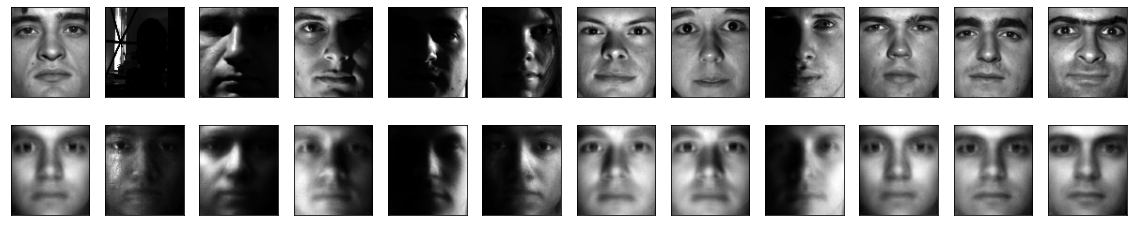

In [35]:
# Representación de casos de ejemplo entre imágenes reales y las del Autoencoder.
n = 12  # número de muestras a observar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imágenes reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+20].reshape(96, 84))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [37]:
#Cargando modelo del encoder 1 con batch = 50, función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop
encoder1_b1_f2_dp_adm = keras.models.load_model(path + 'encoder_t1_b1_f2_dp_adm.h5')

# Creacción del clasificador
initializer = tf.keras.initializers.HeNormal()
reg = tf.keras.regularizers.L2()

classAuto = layers.Dense(units=38, kernel_initializer = initializer, kernel_regularizer= reg, activation='softmax')(encoder1_b1_f2_dp_adm.get_layer('dense_11').get_output_at(node_index=0))
class_Auto = keras.Model(encoder1_b1_f2_dp_adm.get_layer('input_3').get_output_at(node_index=0), classAuto)

In [38]:
# Clasificador
class_Auto.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
result1_b1_f2_dp_adm_class = class_Auto.fit(x_train, y_train, epochs=30, batch_size=20, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/30
95/95 [==============================] - 27s 278ms/step - loss: 4.3263 - accuracy: 0.0446 - val_loss: 4.0411 - val_accuracy: 0.0579
Epoch 2/30
95/95 [==============================] - 33s 348ms/step - loss: 3.8111 - accuracy: 0.1063 - val_loss: 3.5774 - val_accuracy: 0.1579
Epoch 3/30
95/95 [==============================] - 24s 253ms/step - loss: 3.3587 - accuracy: 0.1876 - val_loss: 3.1374 - val_accuracy: 0.2596
Epoch 4/30
95/95 [==============================] - 24s 253ms/step - loss: 2.8743 - accuracy: 0.3417 - val_loss: 2.6287 - val_accuracy: 0.3877
Epoch 5/30
95/95 [==============================] - 24s 253ms/step - loss: 2.2872 - accuracy: 0.5887 - val_loss: 2.0317 - val_accuracy: 0.6456
Epoch 6/30
95/95 [==============================] - 25s 267ms/step - loss: 1.7682 - accuracy: 0.7492 - val_loss: 1.5881 - val_accuracy: 0.7860
Epoch 7/30
95/95 [==============================] - 25s 259ms/step - loss: 1.3537 - accuracy: 0.8581 - val_loss: 1.3204 - val_accuracy: 0.8298

In [40]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
train_loss_list = []

train_loss, train_acc = class_Auto.evaluate(x_train, y_train)
test_loss, test_acc = class_Auto.evaluate(x_test, y_test)

train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

18/18 [==============================] - 1s 76ms/step - loss: 0.3902 - accuracy: 0.9596


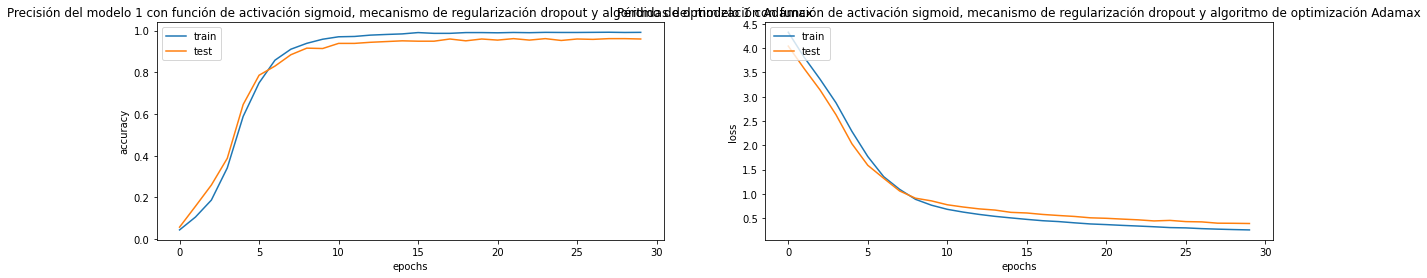

In [41]:
# Imprimir los datos de la topología 1 con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización Adamax del Auto-Encoder y clasificador

# Accuracy
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.plot(result1_b1_f2_dp_adm_class.history['accuracy'])
plt.plot(result1_b1_f2_dp_adm_class.history['val_accuracy'])
plt.title('Precisión del modelo 1 con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización Adamax')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

#Loss
plt.subplot(1,2,2)
plt.plot(result1_b1_f2_dp_adm_class.history['loss'])
plt.plot(result1_b1_f2_dp_adm_class.history['val_loss'])
plt.title('Pérdidas del modelo 1 con función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización Adamax')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Resultados
> Inicialmente observamos que entre las tres topologías implementadas, la que peor rendimiento tuvo fue la topología #3 (exactitud 93,51%). En el caso de las topologias #1 y #2 se presentó un desempeño parecido (exactitud de 95,26%). Por lo tanto se continuó utilizando la topología #1 para el análisis de sensibilidad.

> En relación al análisis de sensiblidad primero se varió el tamaño de los batch. Se utilizaron: 50, 100 y 10, además de la implementación original que estaba configurado en 20. Los resultados arrojaron que:

*   Topología 1 con batch 50 obtuvo una exactitud de 95,79%.
*   Topología 1 con batch 100 obtuvo una exactitud de 95,44%.
*   Topología 1 con batch 10 obtuvo una exactitud de 95,61%.
*   Topología 1 con batch 20 (original) obtuvo una exactitud de 95,26%.

Se analiza que con las variaciones del batch se mantuvieron los resultados cercanos al 95% de exactitud, por esta razón se decide utilizar la topología #1 con batch = 50.

> Después en relación al análisis de sensibilidad se variaron las funciones de activación. Se utilizaron: tanh, sigmoid y Relu que es la de la implementación original. Los resultados arrojaron que:

*   Topología 1 con batch 50 y función de activación Relu (original) obtuvo una exactitud de 95,79%.
*   Topología 1 con batch 50 y función de activación tanh obtuvo una exactitud de 96,49%.
*   Topología 1 con batch 50 y función de activación sigmoid obtuvo una exactitud de 96,49%.

Se observa que con las funciones de activación tanh y Sigmoid se mejoró la exactitud del modelo a un 96,49%. Por consiguiente se escoge la topología #1 con batch = 50 y función de activación sigmoid.

> Seguidamente en relación al análisis de sensibilidad se utilizaron mecanismos de regularización L2, dropout. Los resultados arrojaron que:

*   Topología 1 con batch 50, función de activación sigmoid, y mecanismo de regularización L2 se obtuvo una exactitud de 2,63%.
*   Topología 1 con batch 50, función de activación sigmoid, y mecanismo de regularización dropout se obtuvo una exactitud de 95,96%.

Se observa que la regularización L2 tuvo un efecto negativo al modelo, reduciendo la exactitud a un 2,63%. Por otro lado, en el caso de dropout se mantuvo cercana la exactitud al 96% pero se redujo un poco respecto a la topología implementada donde solo se variaba la función de activación a sigmoid. Aún así, por efectos de aprendizaje se eligió continuar con dropout como método de regularización.

> Finalmente, se hizo un análisis de sensibilidad con tres diferentes algoritmos de optmización, estos fueron: RMSprop, Adamax y Adam de la implementación original. Los resultados arrojaron que:

*   Topología 1 con batch 50, función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización RMSprop se obtuvo una exactitud de 95,26%.
*   Topología 1 con batch 50, función de activación sigmoid, mecanismo de regularización L2 y algoritmo de optimización Adamax se obtuvo una exactitud de 95,96%.
*   Topología 1 con batch 50, función de activación sigmoid, mecanismo de regularización dropout y algoritmo de optimización Adam se obtuvo una exactitud de 95,96%.

Aunque los resultados son buenos, todos mayores al 95% de exactitud, se observa que el resultado de Adamax no fue diferente al de la implementación original de Adam, y que fue incluso un poco más pequeño que el de no utilizar un mecanismo de regularización.

Por consiguiente, a partir del análisis de sensibilidad realizado, se puede decir que el mejor modelo desarrollo fue el de: *topología 1 del auto-encoder de 2 capas de codificación y decodicación; reducción del tamaño a la mitad en cada capa, con función de activación sigmoid y el algoritmo de optimización Adam que obtuvo una exactitud del 96,49%*.














# Conclusiones

*   Se observa que no basta con implementar un modelo de red neuronal y conformarse con los resultados obtenidos. Se debe tomar el tiempo para realizar un análisis de sensibilidad en los hiper-parámetros del modelo implementado. Sea con cambios en el tamaño de batch, los mecanismos de regularización o los algoritmos de optimización, esto conducirá a mejorar los desarrollos y por consiguiente el desempeño del sistema final.
*   En general se obtienen muy buenos resultados para el clasificador conectado al auto-encoder, con una exactitud superior al 95%.
*    A pesar de que solo se realizó un análisis de sensibilidad para el auto-encoder, también se podría realizar una análisis de sensibilidad para el clasificador con el objetivo de mejorar aún más los resultados obtenidos.





# Bibliografía



[1]   Extended Yale B dataset. Disponinle: http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html

[2]   IA: cómo usar un autoencoder-autocodificador para genera imágenes con Keras. Disponible en: https://medium.com/@pablomp3/ia-cómo-usar-un-autoencoder-autocodificador-para-generar-imágenes-con-keras-b838576b7564

[3]   Leer y almacenar imágenes de carpeta con opencv. Disponible en: https://omes-va.com/leer-almacenar-imagenes-de-carpeta-opencv-python/

[4]   Operaciones con archivos y carpetas en Python. Disponible en: https://unipython.com/operaciones-con-archivos-y-carpetas-en-python/

[5]  Keras API reference. Disponible en: https://keras.io/api/







